In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import seaborn as sns
import pickle

In [2]:
df = pd.read_csv("../data/cleanedData.csv")

In [3]:
X = df.drop(['label'], axis=1)
y = df['label']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [5]:
binary_cols = ['urls', 'generalConsumer', 'govDomain', 'eduDomain', 'orgDomain', 'netDomain', 'otherDomain', 'html']
cont_cols = ['punctuationCount', 'subjectLength', 'bodyLength', 'totalLength']

In [6]:
def to_csr(x):
    return csr_matrix(x)

In [7]:
binary_transformer = FunctionTransformer(func=to_csr, accept_sparse=True)

In [8]:
ct = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'fullContent'),
        ('binary', binary_transformer, binary_cols),
        ('cont', StandardScaler(), cont_cols)
    ],
)


In [9]:
transformed_X_train = ct.fit_transform(X_train)
transformed_X_test = ct.transform(X_test)

In [10]:
print(f"Training Dataset: {transformed_X_train.shape}")
print(f"Testing Dataset: {transformed_X_test.shape}")

Training Dataset: (35432, 227096)
Testing Dataset: (8858, 227096)


In [11]:
randf = RandomForestClassifier()
randf.fit(transformed_X_train, y_train)
train_pred = randf.predict(transformed_X_train)



In [12]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10, 20],
    "criterion": ["gini", "entropy"]
}

grid_search = GridSearchCV(estimator=randf, param_grid=param_grid, cv=5, scoring="accuracy", n_jobs=-1)

In [13]:
grid_search.fit(transformed_X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [14]:
print(f"Best Hyperparameters: {grid_search.best_params_}")

Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'n_estimators': 200}


In [15]:
def printCM(predictLabels, trueLabels):
    class_report = classification_report(trueLabels, predictLabels)
    print(class_report)

    cm = confusion_matrix(trueLabels, predictLabels)

    # Define class labels for the confusion matrix (for binary classification)
    class_labels = ['Phishing', 'Non-Phishing']  # Adjust according to your classes

    # Create the heatmap without annotations (annot=False)
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False)

    # Set axis labels
    ax.set_xlabel('True', fontsize=12)
    ax.set_ylabel('Predicted', fontsize=12)

    # Set the class labels on the axes
    ax.set_xticklabels(class_labels, fontsize=10)
    ax.set_yticklabels(class_labels, fontsize=10)

    # Set title
    plt.title('Confusion Matrix')

    # Manually add True Positive, False Positive, True Negative, and False Negative annotations
    # You must use the exact cell positions for each term in the 2x2 confusion matrix
    ax.text(0.5, 0.5, 'TP\n(' + str(cm[1, 1]) + ')', ha='center', va='center', fontsize=12)
    ax.text(1.5, 0.5, 'FP\n(' + str(cm[0, 1]) + ')', ha='center', va='center', fontsize=12)
    ax.text(0.5, 1.5, 'FN\n(' + str(cm[1, 0]) + ')', ha='center', va='center', fontsize=12)
    ax.text(1.5, 1.5, 'TN\n(' + str(cm[0, 0]) + ')', ha='center', va='center', fontsize=12)

    # Show the plot
    plt.tight_layout()
    return plt.show()

In [16]:
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(transformed_X_test)

In [17]:
test_accuracy = accuracy_score(y_test, y_test_pred)

In [18]:
print("Model Accuracy on test dataset: {0:0.4f}".format(test_accuracy))

Model Accuracy on test dataset: 0.9800


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4210
           1       0.99      0.97      0.98      4648

    accuracy                           0.98      8858
   macro avg       0.98      0.98      0.98      8858
weighted avg       0.98      0.98      0.98      8858



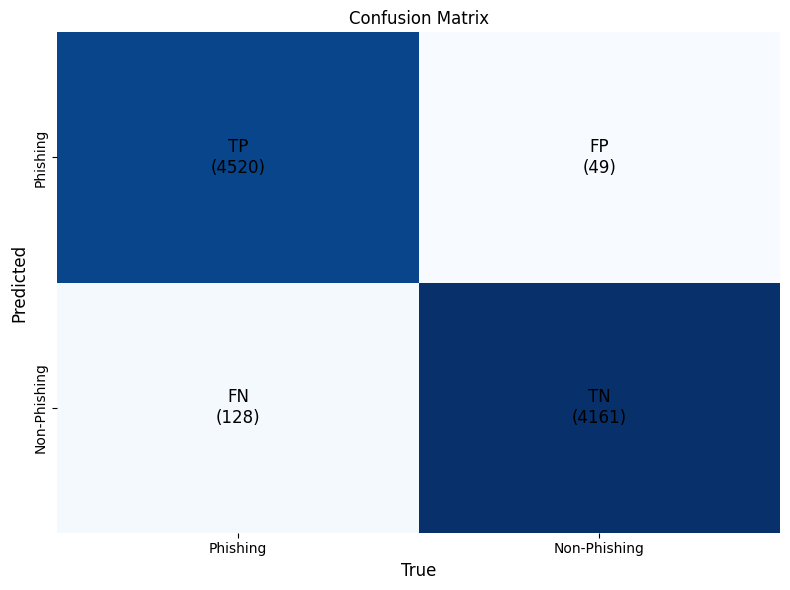

In [19]:
printCM(y_test_pred, y_test)

In [20]:
with open('../model/randomforestclassifier_daniel.pkl', 'wb') as file: pickle.dump(best_model, file)